# Predicting the amount of extracted gold

In this project, we will study three datasets containing information about gold extraction and purification. Our objective is to construct a machine learning model capable of predicting the quantity of gold that will be extracted. This prediction will be based on various parameters supplied within the datasets.

## Importing libraries, modules, and dataframes

In [1]:
# Importing essential libraries and modules for this project

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

In [2]:
# Reading the dataframes

train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
# Information about the train dataframe

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
# Information about the test dataframe

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [5]:
# Information about the full dataframe

full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


These dataframes each contain more than 50 columns, and some of them have missing values. Rather than analyzing and treating information for each individual column, we have decided to remove columns with null information. Although this approach may result in the loss of some interesting details, navigating through variables in datasets with this many columns is impractical and could potentially lead to misinterpretations.

In [6]:
# Dropping rows with null values

test = test.dropna()
train = train.dropna()
full = full.dropna()

print(f'{test.shape}, {train.shape}, {full.shape}')

(5383, 53), (11017, 87), (16094, 87)


Initially, we need to analyze the dataframe, which displays four stages (rougher, primary cleaner, secondary cleaner, and final). Each stage encompasses specific characteristics:

**Rougher Stage:**

Inputs: Elements utilized in the process.
Outputs: Concentration and tail for certain elements, along with the recovery - a key characteristic.
Additional information includes calculation details and various states.

**Primary Cleaner Stage:**

Inputs: Elements related to the input information.
Outputs: Concentration and tails for specific elements, along with state information.

**Secondary Cleaner Stage:**

Columns primarily consist of states.
Outputs: Tails for the considered elements.

**Final Stage:**

Outputs: Concentration and tails for elements from previous stages, along with recovery information specific to this stage.

## Data processing

First, we will convert the data type of the index to datetime, considering the potential significance of this information for our study.

In [7]:
# Correcting dates datatype

train['date'] = pd.to_datetime(train['date'], format='%Y%m%d %H:%M:%S')
test['date'] = pd.to_datetime(test['date'], format='%Y%m%d %H:%M:%S')
full['date'] = pd.to_datetime(full['date'], format='%Y%m%d %H:%M:%S')

# Checking the result

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                11017 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         11017 non-null  float64       
 2   final.output.concentrate_pb                         11017 non-null  float64       
 3   final.output.concentrate_sol                        11017 non-null  float64       
 4   final.output.concentrate_au                         11017 non-null  float64       
 5   final.output.recovery                               11017 non-null  float64       
 6   final.output.tail_ag                                11017 non-null  float64       
 7   final.output.tail_pb                                11017 non-null  float64       
 8   final.

In [8]:
# Verifying the presence of duplicated rows in each dataframe.

print(f'{train.duplicated().sum()}, {test.duplicated().sum()}, {full.duplicated().sum()}')

0, 0, 0


No duplicated rows were identified in the dataframes. However, an issue is apparent in the information print: the test dataframe has a significantly lower number of columns compared to the other dataframes. As we intend to employ this dataframe for model testing, only the information present in it should be considered for constructing our models. Consequently, we will remove the unnecessary columns, as they will not contribute to our analysis.

In [9]:
# Determining the number of columns in each dataframe.

print(f'{train.columns.size}, {full.columns.size}, {test.columns.size}')

87, 87, 53


In [10]:
# Missing columns in the test dataset

list = []

for element in train.columns:
    if element not in test.columns:
        list.append(element)
        
list

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

All the missing columns correspond to outputs and calculation parameters. In fact, this will not be useful for our training since this information is part of what we want to predict. The crucial outputs, such as recovery, will be estimated by our models. Additionally, the calculation parameters correspond to information from other columns, which should be disregarded to avoid providing redundant information to the model.

In [11]:
# Dropping unnecessary columns.

processed_train = train[test.columns.to_list() + ['final.output.recovery', 'rougher.output.recovery']]
processed_full = full[test.columns.to_list() + ['final.output.recovery', 'rougher.output.recovery']]

# Checking

print(f'{processed_train.shape}, {processed_full.shape}')

(11017, 55), (16094, 55)


Now, we are exclusively considering information that will be used during the testing phase of our machine learning project. Finally, the data appears to be consistent.

## Data Exploration

### Recovery calculation

The recovery is our target in this project, both after the rougher and the secondary cleaner stages. This measure can also be calculated using the concentration, feed, and tail of gold after a process. It's worthwhile to investigate whether the calculated recovery aligns closely with the measured value.

In [12]:
# Generating a column for calculated recovery (%)

def recovery(concentrate, feed, tail):
    
    return 100*(concentrate*(feed-tail))/(feed*(concentrate-tail))

full['recovery'] = recovery(full['rougher.output.concentrate_au'], full['rougher.input.feed_au'], full['rougher.output.tail_au'])

full[['recovery', 'rougher.output.recovery']]

,recovery,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
22711,89.574376,89.574376
22712,87.724007,87.724007
22713,88.890579,88.890579
22714,89.858126,89.858126


In [13]:
# Calculating the mean absolute error

mae = mean_absolute_error(full['rougher.output.recovery'], full['recovery'])

mae

1.13170729570688e-14

The value is remarkably low, suggesting that the measure taken is accurate. We will proceed with further analysis.

### Analyzing metals concentrations

Among the various pieces of information that we could analyze with these dataframes, the concentrations of metals after each stage are particularly intriguing. This is pertinent to our study of recovery, as it is directly linked to these concentrations.

<AxesSubplot:ylabel='Frequency'>

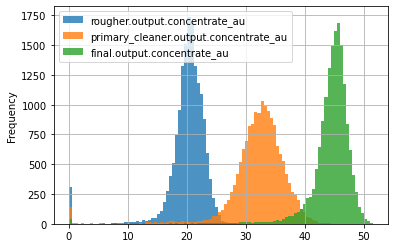

In [14]:
# Comparing the gold concentration after each stage

full[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au' , 'final.output.concentrate_au']].plot(
    kind = 'hist', bins = 100, alpha = 0.8, grid = True)

<AxesSubplot:ylabel='Frequency'>

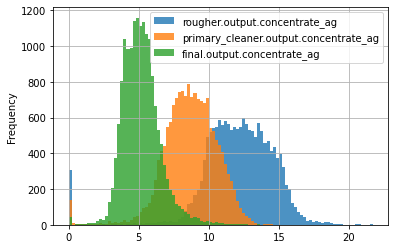

In [15]:
# Comparing the silver concentration after each stage

full[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag' , 'final.output.concentrate_ag']].plot(
    kind = 'hist', bins = 100, alpha = 0.8, grid = True)

<AxesSubplot:ylabel='Frequency'>

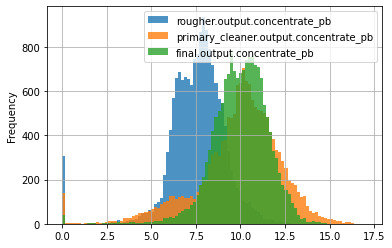

In [16]:
# Comparing the lead concentration after each stage

full[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb' , 'final.output.concentrate_pb']].plot(
    kind = 'hist', bins = 100, alpha = 0.8, grid = True)

It's noticeable that the gold concentration increases after each process, evident in the three well-defined curves. Conversely, for silver, there is a decreasing trend, with lower concentration in the last stage. Regarding lead, there's a similar concentration after the second and third stages, but the concentration in the final stage varies more than in the other two.

Additionally, it's interesting to observe some zero values in the metal concentration column. In a gold extraction process, having a null concentration after the first stage seems unusual.

<AxesSubplot:ylabel='Frequency'>

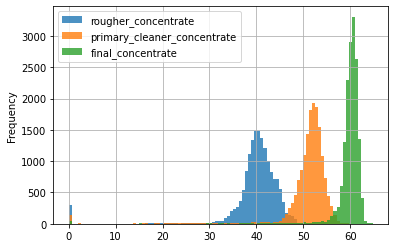

In [17]:
# Summing up the concentrations for the three metals.

full['final_concentrate'] = full['final.output.concentrate_ag'] + full['final.output.concentrate_au'] + full['final.output.concentrate_pb']
full['primary_cleaner_concentrate'] = full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_au'] + full['primary_cleaner.output.concentrate_pb']
full['rougher_concentrate'] = full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_pb']

full[['rougher_concentrate', 'primary_cleaner_concentrate' , 'final_concentrate']].plot(
    kind = 'hist', bins = 100, alpha = 0.8, grid = True)

The distribution of metals increases for each phase, indicating that the concentration of metals is indeed rising, aligning with the desired outcome of the process. However, since the presence of zeros persists, we will proceed to remove this data from the train dataframe.

In [18]:
# Dropping rows with zero concentration in some stage.

train_final_concentrate = train['final.output.concentrate_ag'] + train['final.output.concentrate_au'] + train['final.output.concentrate_pb']
train_primary_cleaner_concentrate = train['primary_cleaner.output.concentrate_ag'] + train['primary_cleaner.output.concentrate_au'] + train['primary_cleaner.output.concentrate_pb']
train_rougher_concentrate = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_au'] + train['rougher.output.concentrate_pb']

list_zeros_train = train_final_concentrate[train_final_concentrate == 0].index.to_list() + train_primary_cleaner_concentrate[train_primary_cleaner_concentrate == 0].index.to_list() + train_rougher_concentrate[train_rougher_concentrate == 0].index.to_list()

processed_train = processed_train.drop(list_zeros_train, axis = 0)

processed_train

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,70.541216,87.107763
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,69.266198,86.843261
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,68.116445,86.842308
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,68.347543,87.226430
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,66.927016,86.688794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,2018-08-18 06:59:59,123.381787,8.028927,6.50,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,...,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428,73.755150,89.574376
16856,2018-08-18 07:59:59,120.878188,7.962636,6.50,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,...,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608,69.049291,87.724007
16857,2018-08-18 08:59:59,105.666118,7.955111,6.50,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,...,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452,67.002189,88.890579
16858,2018-08-18 09:59:59,98.880538,7.984164,6.50,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,...,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,65.523246,89.858126


### Analyzing the particle size

It's crucial to verify if certain information exhibits similar distributions between the test and train dataframes, such as particle size.

<AxesSubplot:ylabel='Frequency'>

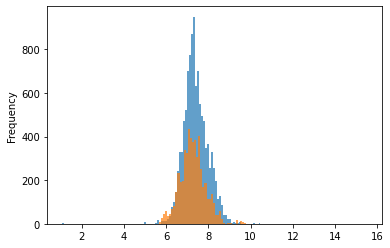

In [19]:
# Comparing the feed size for the primary cleaner

processed_train['primary_cleaner.input.feed_size'].plot(kind = 'hist', bins = 100, alpha = 0.7)
test['primary_cleaner.input.feed_size'].plot(kind = 'hist', bins = 100, alpha = 0.7)

<AxesSubplot:ylabel='Frequency'>

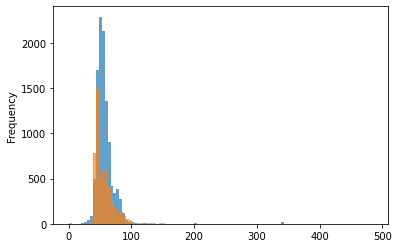

In [20]:
# Comparing the feed size for rougher

processed_train['rougher.input.feed_size'].plot(kind = 'hist', bins = 100, alpha = 0.7)
test['rougher.input.feed_size'].plot(kind = 'hist', bins = 100, alpha = 0.7)

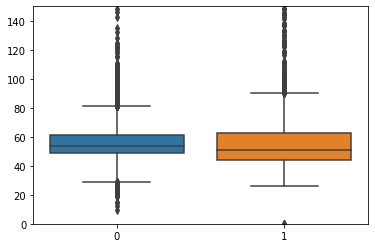

In [21]:
# Comparing the feed size for rougher (with boxplots)

sns.boxplot(data = [processed_train['rougher.input.feed_size'], test['rougher.input.feed_size']])

plt.ylim((0, 150))
plt.show()

The distribution is similar in each dataframe, indicating no issues. Therefore, we will proceed with the construction of our machine learning model.

## Developing a machine learning model

Our objective is to construct a machine learning model that predicts the proportion of recovery after the rougher (25%) and in the final stage (75%). We will experiment with various models and select the one that yields the lowest error value.

In [22]:
# Creating dataframes with features and targets

features_train = processed_train.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis=1).values
targets_train = processed_train[['final.output.recovery', 'rougher.output.recovery']].values

print(features_train.shape, targets_train.shape)

(10737, 52) (10737, 2)


In [23]:
# Applying a scaler to enhance the performance of the model.

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

In [24]:
# Function that returns the target value

def sMAPE(target, predicted):
    return 100 * np.mean(np.abs(target - predicted) / ((np.abs(target) + np.abs(predicted)) / 2))

def sMAP_final(target, predicted):
    rougher = sMAPE(target[:, 0], predicted[:, 0])
    final = sMAPE(target[:, 1], predicted[:, 1])
    
    return rougher * 0.25 + final * 0.75

# Converting the function into a scorer for our models

sMAP_scorer = make_scorer(sMAP_final, greater_is_better=False)

In [25]:
# Trying Linear Regression as model

model_lr = LinearRegression()

score = cross_val_score(model_lr, X=features_train, y=targets_train, scoring=sMAP_scorer, cv=5)

print(np.mean(np.abs(score)))

6.873378917164604


In [26]:
# Trying Random Forest Regressor as model

best_n_estimator = 0
best_score = 100

for i in range(1, 101, 20):
    
    model_rf = RandomForestRegressor(random_state = 12345, n_estimators = i)
    score = cross_val_score(model_rf, X = features_train, y = targets_train, scoring = sMAP_scorer, cv = 3)
    score_mean = np.mean(score)
    print(f'For n_estimator = {i}, the score is {np.abs(score_mean)}')
    if np.abs(score_mean) < best_score:
        best_score = np.abs(score_mean)
        best_n_estimator = i
        
print(f'The best score is {best_score} for max_depth = {best_n_estimator}')

For n_estimator = 1, the score is 9.922465040702171
For n_estimator = 21, the score is 7.820772653656467
For n_estimator = 41, the score is 7.684999042694764
For n_estimator = 61, the score is 7.686009824300025
For n_estimator = 81, the score is 7.671918165275187
The best score is 7.671918165275187 for max_depth = 81


In [27]:
# Trying Decision Tree Regressor as model

best_depth = 0
best_score = 100

for depth in range(1, 10):
    
    model_dt = DecisionTreeRegressor(random_state = 12345, max_depth = depth)
    score = np.mean(cross_val_score(model_dt, X = features_train, y = targets_train, scoring = sMAP_scorer, cv = 5))
    print(f'For max depth = {depth}, the score is {np.abs(score)}')
    if np.abs(score) < best_score:
        best_score = np.abs(score)
        best_depth = depth
        
print(f'The best score is {best_score} for max_depth = {best_depth}')

For max depth = 1, the score is 6.907771456585834
For max depth = 2, the score is 7.073950271058209
For max depth = 3, the score is 7.16787970180039
For max depth = 4, the score is 7.074559464481297
For max depth = 5, the score is 7.223224467723531
For max depth = 6, the score is 7.604331586676068
For max depth = 7, the score is 7.6158714375530945
For max depth = 8, the score is 8.090057654428469
For max depth = 9, the score is 8.64813373169973
The best score is 6.907771456585834 for max_depth = 1


The best result, indicated by the lowest error, was obtained using the Linear Regression model. Therefore, we will proceed with this model for our test dataframe.

In [28]:
processed_test = test.merge(full[['date', 'final.output.recovery', 'rougher.output.recovery']], on = 'date', how = 'left').dropna()

features_test = processed_test.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis=1)
targets_test = processed_test[['final.output.recovery', 'rougher.output.recovery']]

features_test = scaler.transform(features_test)

final_model = LinearRegression()
final_model.fit(features_train, targets_train)
predicted = final_model.predict(features_test)

sMAP_final(targets_test.to_numpy(), predicted)

8.140049461800796

## Conclusion

After thorough investigation of the dataframes, we explored three model possibilities to construct our machine learning model. The development process involved an examination of particle size, the presence of zeros in metal concentrations, and the concentration evolution of each metal in each stage. Ultimately, we selected the Linear Regression model, which yielded the best result. Applying this model to our test dataframe, we achieved a final score of 8.14%.